In this notebook, we test the `aqt` library to make sure that we get correctly quantized dot products and hadamard products. The main caveat is that we want to have more control over the calibration axes that are used for the quantization, which is why we're using our own fork of the `aqt` library. See docstrings in the `quant_dot_for_hadamard` and `quant_dot_for_dot` functions below.

In [1]:
from aqt.jax.v2.aqt_dot_general import CalibrationMode
import aqt.jax.v2.config as aqt_config
import jax
import jax.numpy as jnp
from functools import partial
import matplotlib.pyplot as plt

/home/legion/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# NOTE: we could also be using CalibrationMode.NON_BATCH_AXES for the dot product,
# which would allow us to add batch dimensions directly into the dot product.
# The hadamard product does not support this, however, so we will add the batch
# dimensions with vmap instead, so we will use CalibrationMode.ALL_AXES for all.

# use all axes for calibration -> add batch with vmap
fully_quantized = partial(
    aqt_config.fully_quantized, 
    calibration_mode=CalibrationMode.ALL_AXES, use_stochastic_rounding=False,
)

def quant_dot_for_hadamard(dot_general):
    """Generate a jitted general_dot function to be used for hadamard products.
    Note that this function does not support batch dimensions. All dimensions will
    be used for calibration in the quantization."""
    def _dot(a, b):
        contr_dims = ((), ())  # hadamard has no contracting dims
        batch_dims = (tuple(range(a.ndim)), tuple(range(b.ndim)))  # use all dims as batch dims
        return dot_general(a, b, (contr_dims, batch_dims))
    return jax.jit(_dot)

def quant_dot_for_dot(general_dot):
    """Generate a jitted general_dot function to be used for dot products.
    Will contract on the last dimension of a, and the first dimension of b.
    This means that there are no batch dimensions, and all dimensions will be used
    for calibration in the quantization."""
    def _dot(a, b):
        # contr_dims = ((a.ndim-1,), (1,))  # batched version (not used)
        # batch_dims = ((0,), (0,))  # batched version (not used)
        contr_dims = ((a.ndim-1,), (0,))
        batch_dims = ((), ())
        return general_dot(a, b, (contr_dims, batch_dims))
    return jax.jit(_dot)

In [3]:
int8_config = fully_quantized(fwd_bits=8, bwd_bits=8)
int4_config = fully_quantized(fwd_bits=4, bwd_bits=4)
int2_config = fully_quantized(fwd_bits=2, bwd_bits=2)
int1_config = fully_quantized(fwd_bits=1, bwd_bits=1)

key = jax.random.PRNGKey(0)

Hadamard

In [4]:
qd = quant_dot_for_hadamard(int1_config)
a, b = jnp.split(jax.random.normal(key, (200,)), 2)
res = qd(a, b)
# print(res)
# print(jnp.unique(res))
print(f'# unique vals: {jnp.unique(res).shape[0]} (expected: 2)')

# unique vals: 2 (expected: 2)


In [5]:
qd = quant_dot_for_hadamard(int2_config)
a, b = jnp.split(jax.random.normal(key, (2000,)), 2)
res = qd(a, b)
# print(res)
# print(jnp.unique(res))
print(f'# unique vals: {jnp.unique(res).shape[0]} (expected: 4)')

# unique vals: 3 (expected: 4)


In [6]:
qd = quant_dot_for_hadamard(int4_config)
a, b = jnp.split(jax.random.normal(key, (100,)), 2)
res = qd(a, b)
# print(res)
# print(jnp.unique(res))
print(f'# unique vals: {jnp.unique(res).shape[0]} (expected: 16)')
# print(res)

# unique vals: 24 (expected: 16)


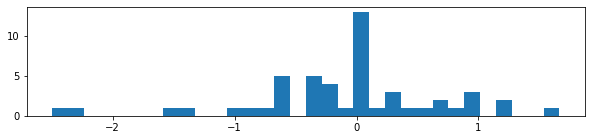

In [7]:
fig, ax = plt.subplots(figsize=(10, 2))
ax.hist(res, bins=32);

In [8]:
qd = quant_dot_for_hadamard(int8_config)
a, b = jnp.split(jax.random.normal(key, (10_000,)), 2)
res = qd(a, b)
# print(res)
# print(jnp.unique(res))
print(f'# unique vals: {jnp.unique(res).shape[0]} (expected: 256)')

# unique vals: 1945 (expected: 256)


vmap'ed hadamard

In [10]:
qd = jax.vmap(quant_dot_for_hadamard(int2_config))
a, b = jnp.split(jax.random.normal(key, (4, 100,)), 2)
print(a.shape, b.shape)
res = qd(a, b)
# print(res)
# print(jnp.unique(res))
print(f'# unique vals: {jnp.unique(res).shape[0]} (expected: 4)')

(2, 100) (2, 100)
# unique vals: 5 (expected: 4)


Dot

In [11]:
qd = quant_dot_for_dot(int1_config)
a, b = jnp.split(jax.random.normal(key, (4, 20)), 2)
b = b.T
print(a.shape, b.shape)
res = qd(a, b)
# print(res)

x = jnp.unique(res)
x = x / abs(x[x != 0]).min()
all_multiples = jnp.allclose(jnp.mod(x, 1), 0, atol=1e-5)
max_coeff = jnp.max(jnp.abs(x)).item()
print(f'all multiples: {all_multiples}, max coeff: {max_coeff}')
# print(jnp.unique(res))
# print(f'# unique vals: {jnp.unique(res).shape[0]} (expected: 2)')

(2, 20) (20, 2)
all multiples: True, max coeff: 4.0


In [12]:
qd = quant_dot_for_dot(int2_config)
a, b = jnp.split(jax.random.normal(key, (4, 20)), 2)
b = b.T
print(a.shape, b.shape)
res = qd(a, b)
# print(res)

x = jnp.unique(res)
x = x / abs(x[x != 0]).min()
all_multiples = jnp.allclose(jnp.mod(x, 1), 0, atol=1e-5)
max_coeff = jnp.max(jnp.abs(x)).item()
print(f'all multiples: {all_multiples}, max coeff: {max_coeff}')
# print(jnp.unique(res))
# print(f'# unique vals: {jnp.unique(res).shape[0]} (expected: 2)')

(2, 20) (20, 2)
all multiples: True, max coeff: 2.0


In [13]:
qd = quant_dot_for_dot(int4_config)
a, b = jnp.split(jax.random.normal(key, (4, 20)), 2)
b = b.T
print(a.shape, b.shape)
res = qd(a, b)
# print(res)

x = jnp.unique(res)
x = x / abs(x[x != 0]).min()
all_multiples = jnp.allclose(jnp.mod(x, 1), 0, atol=1e-5)
max_coeff = jnp.max(jnp.abs(x)).item()
print(f'all multiples: {all_multiples}, max coeff: {max_coeff}')
# print(jnp.unique(res))
# print(f'# unique vals: {jnp.unique(res).shape[0]} (expected: 2)')

(2, 20) (20, 2)
all multiples: False, max coeff: 5.111111640930176


In [14]:
qd = quant_dot_for_dot(int8_config)
a, b = jnp.split(jax.random.normal(key, (4, 20)), 2)
b = b.T
print(a.shape, b.shape)
res = qd(a, b)
# print(res)

x = jnp.unique(res)
x = x / abs(x[x != 0]).min()
all_multiples = jnp.allclose(jnp.mod(x, 1), 0, atol=1e-5)
max_coeff = jnp.max(jnp.abs(x)).item()
print(f'all multiples: {all_multiples}, max coeff: {max_coeff}')
# print(jnp.unique(res))
# print(f'# unique vals: {jnp.unique(res).shape[0]} (expected: 2)')

(2, 20) (20, 2)
all multiples: False, max coeff: 6.111774444580078


In [24]:
jnp.dot(a,b)

Array([[-1.3960272,  4.4675193],
       [-8.494822 , -2.3419282]], dtype=float32)

In [39]:
fully_quantized_v3 = aqt_config.config_v3

int4_config_v3 = fully_quantized_v3(fwd_bits=4, dlhs_bits=4, drhs_bits=4, fwd_accumulator_dtype=jnp.int8, dlhs_accumulator_dtype=jnp.int8, drhs_accumulator_dtype=jnp.int8)
#int4_config_v3 = fully_quantized_v3(fwd_bits=4, bwd_bits=4)
#int2_config_v3 = fully_quantized_v3(fwd_bits=2, bwd_bits=2)
#int1_config_v3 = fully_quantized_v3(fwd_bits=1, bwd_bits=1)

In [40]:
qd = quant_dot_for_dot(int4_config)
qd(a,b)

Array([[-1.4792789,  4.026926 ],
       [-7.560759 , -1.7258254]], dtype=float32)

In [41]:
qd = quant_dot_for_dot(int4_config_v3)
qd(a,b)

Array([[-1.9700532,  3.8667667],
       [-7.560759 , -2.634647 ]], dtype=float32)